<a href="https://colab.research.google.com/github/Xi-HHHM/test-note-book/blob/main/Copy_of_Echtzeitsysteme_(copy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install control
!pip install matplotlib

import control as ctrl
import matplotlib.pyplot as plt
import numpy as np


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

Exercise for Segway


Transfer function of this linearized system:  
       1
---------------
2 s^2 + s - 9.8

Poles of G_ip:  [-2.47766694  1.97766694]


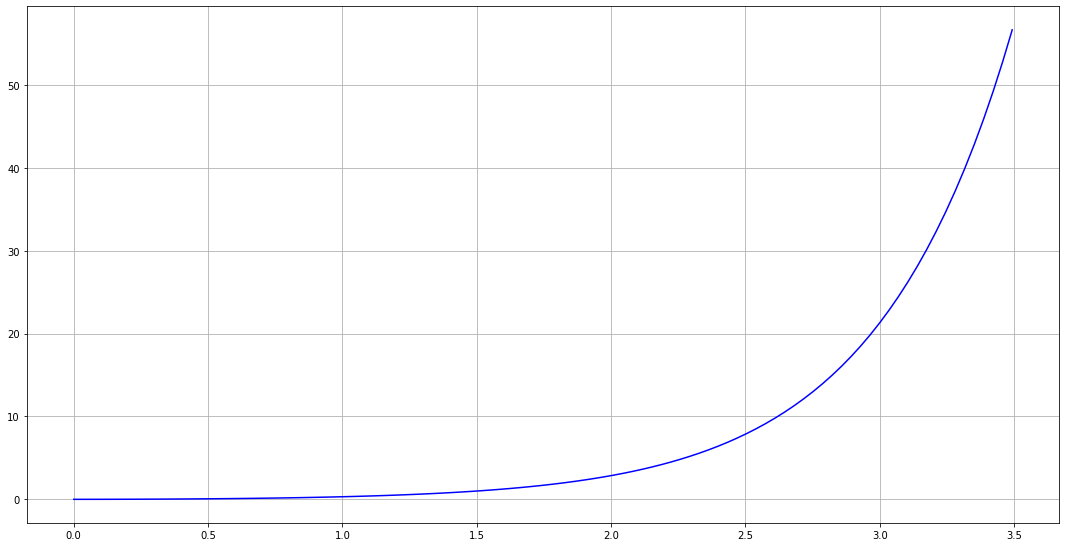

In [ ]:
# Initailize the parameters of the model
Js = 1.0
m  = 1.0
d  = 1.0
l  = 1.0
g  = 9.8

# Transfer function of the inverted pendulum.
G_ip = ctrl.tf([m*l], [(Js + m*l**2), d, -m*l*g ])
print("Transfer function of this linearized system: ", G_ip)
print("Poles of G_ip: ", ctrl.pole(G_ip))

# Step response of this system --> Not stable
ret = ctrl.step_response(G_ip)
plt.plot(ret[0], ret[1], 'b-')
plt.grid(True)
plt.gcf().set_size_inches(18.5, 9.5, forward=True)
 


In [ ]:
# Design a controller to control this system

# Controller 1: PID-Controller
k_p = 1 # @param {type:"number"}
k_i =   2# @param {type:"number"} 
k_d =   4# @param {type:"number"}

# 
R_pid = ctrl.tf([k_p], [1]) + ctrl.tf([k_d, 0], [1]) + ctrl.tf([k_i], [1, 0])
print("Transfer function of the controller", R_pid) 


Transfer function of the controller 
4 s^2 + s + 2
-------------
      s




      4 s^2 + s + 2
-------------------------
2 s^3 + 5 s^2 - 8.8 s + 2



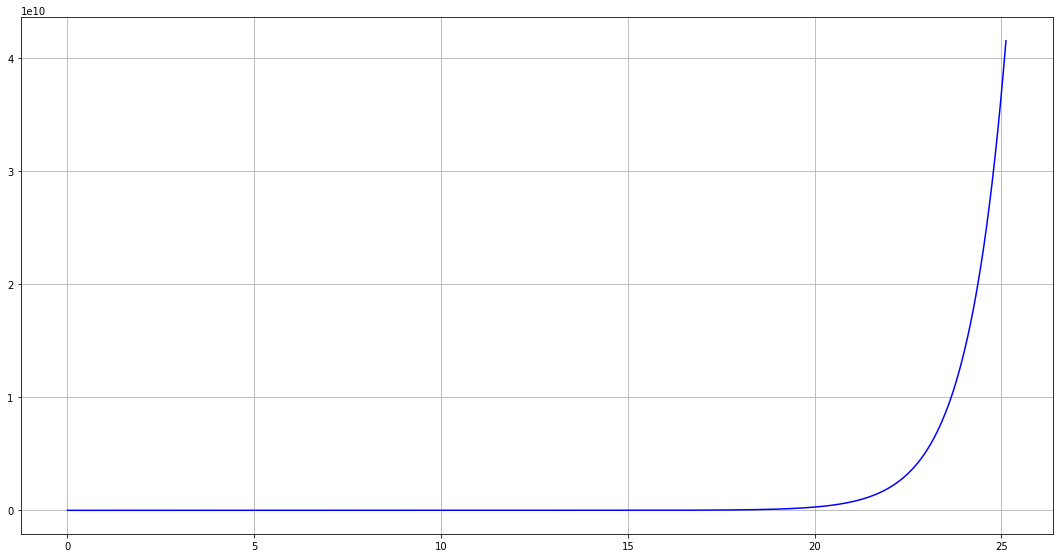

In [ ]:
# Combine the controller and the system, and close the loop
G_pid_ip = R_pid*G_ip
G_pid_ip_close_loop = ctrl.feedback(G_pid_ip)

print(G_pid_ip_close_loop)

# Step response of this system --> Not stable
ret = ctrl.step_response(G_pid_ip_close_loop)
plt.plot(ret[0], ret[1], 'b-')
plt.grid(True)
plt.gcf().set_size_inches(18.5, 9.5, forward=True)


The state feedback coefficients K:  [[ 9.5 28.9]]
State space of the new feed-forwards system: 
A = [[-10. -24.]
     [  1.   0.]]

B = [[1.]
     [0.]]

C = [[0.  0.5]]

D = [[0.]]

Poles:  [-6. -4.]


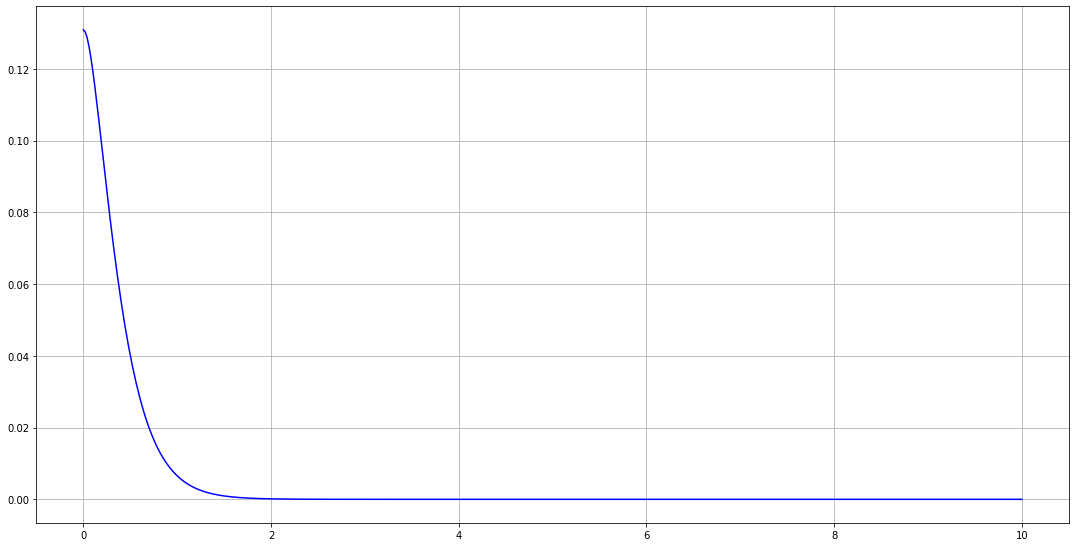

In [ ]:
# Controller 2: State feedback controller
# Recall that the state space formulation of a system
# A_dot = A*x + b*u
# y = C*x + D*u
A = ctrl.tf2io(G_ip).A
b = ctrl.tf2io(G_ip).B
C = ctrl.tf2io(G_ip).C
d = ctrl.tf2io(G_ip).D

p = [-4, -6] # @param
K = ctrl.acker(A, b, p)

print("The state feedback coefficients K: ", K)

A_st_feedback = A;

A_st_feedback[0, :] = A[0, :] - K
b_st_feedback = np.zeros_like(b)

ctrl_G_ip = ctrl.ss(A_st_feedback, b, C, d)

# 
print("State space of the new feed-forwards system: ") 
print(ctrl_G_ip)
print("Poles: ", ctrl.pole(ctrl_G_ip))

T = np.linspace(0, 10, 500) # From 0 to 10s, step size 0.02s
phi_ref = np.zeros_like(T)

X0 = [0, (15/180*np.pi)]
ctrl_G_ip_io = ctrl.iosys.LinearIOSystem(ctrl_G_ip)
t, y = ctrl.input_output_response(ctrl_G_ip_io, T, [phi_ref], X0)

# Step response of this system --> Stable
plt.plot(t, y, 'b-')
plt.grid(True)
plt.gcf().set_size_inches(18.5, 9.5, forward=True)

In [ ]:
# Consider the code here: https://python-control.readthedocs.io/en/0.8.3/generated/control.iosys.InterconnectedSystem.html

def inverted_pendulum_update(x, u, params={}):
    """Dynamics of the inverted pendulum system

    Parameters
    ----------
    x : array
         System state: [phi, omega], the angular position and velocity of the
         mass point.
    u : array
         System input: [x_acc], The acceleration of the cart

    Returns
    -------
    float
        Angular acceleartion.

    """
    from math import cos, sin
    
    # Set up the system parameters
    m = params.get('m', 1)
    g = params.get('g', 9.8)
    l = params.get('l', 1)
    d = params.get('d', 1)
    Js = params.get('Js', 1)

    # Define variables for vehicle state and inputs
    phi = x[1]                      # angular position
    omega = x[0]                    # angular velocity
    cart_acc = u[0]                 # vehicle gear

    omega_dot = (m*l*(cart_acc*cos(phi) + g*sin(phi)) - d*omega)/(Js + m*l**2)
    return omega_dot


# Define the input/output system for the inverted pendulum
# u -> x_acc
# x -> [phi, omega]
# inv_pendulum = ctrl.NonlinearIOSystem(
#     inverted_pendulum_update, name='inv_pendulum',
#     inputs = ('u'), outputs=('omega', 'phi'), states=('omega', 'phi'))


def st_feedback_ctrl_update(x, u, params={}):
  k1 = params.get('k1', 9.5)
  k2 = params.get('k2', 28.9)

  return -(k1*u[0] + k2*u[1])


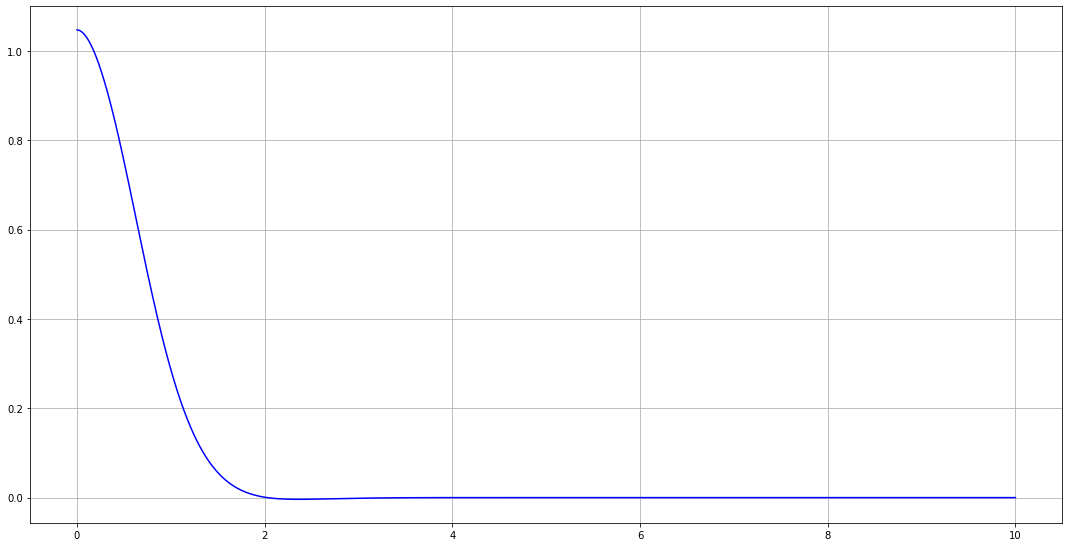

In [ ]:
X0 = np.array([[0], [(60/180*np.pi)]])
T = np.linspace(0, 10, 5000)
dt = T[1] - T[0]
phi = np.zeros_like(T)
x = X0

k1 =  9.6#@param {type:"number"}
k2 =  28.9#@param {type:"number"}

for i, t in enumerate(T):
  ctrl_output = st_feedback_ctrl_update(x=0, u=x, params={'k1': k1, 'k2': k2})
  omega_dot = inverted_pendulum_update(x=x, u=ctrl_output, params={})
  x[0] += omega_dot*dt
  x[1] += x[0]*dt
  phi[i] = x[1]


# Step response of this system --> Stable
plt.plot(T, phi, 'b-')
plt.grid(True)
plt.gcf().set_size_inches(18.5, 9.5, forward=True)

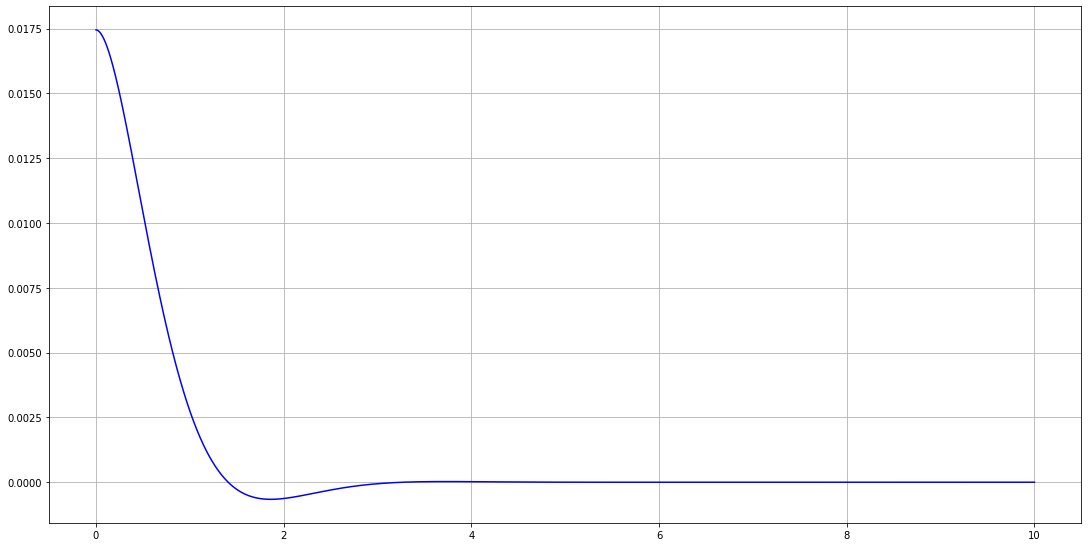

In [ ]:
def nonlinear_ctrl_update(x, u, params={}):
  g = params.get('g', 9.8)
  k_1 = params.get('k1', 20)
  k_2 = params.get('k2', 2)
  phi = u[1]
  omega = u[0]
  from math import cos, sin
  x_ddot = -k_1*(g*sin(phi) + phi)/cos(phi) - k_2*omega
  return x_ddot

# Nonlinear controller
X0 = np.array([[0], [(1/180*np.pi)]])
T = np.linspace(0, 10, 5000)
dt = T[1] - T[0]
phi = np.zeros_like(T)
x = X0
k1 =  2# @param
k2 =  6# @param



for i, t in enumerate(T):
  ctrl_output = nonlinear_ctrl_update(x=0, u=x, params={'k1' : k1, 'k2' : k2})
  omega_dot = inverted_pendulum_update(x=x, u=ctrl_output, params={})
  x[0] += omega_dot*dt
  x[1] += x[0]*dt
  phi[i] = x[1]

# Step response of this system --> Stable
plt.plot(T, phi, 'b-')
plt.grid(True)
plt.gcf().set_size_inches(18.5, 9.5, forward=True)

